In [2]:
pip install praw

  Obtaining dependency information for praw from https://files.pythonhosted.org/packages/73/ca/60ec131c3b43bff58261167045778b2509b83922ce8f935ac89d871bd3ea/praw-7.8.1-py3-none-any.whl.metadata
  Obtaining dependency information for prawcore<3,>=2.4 from https://files.pythonhosted.org/packages/96/5c/8af904314e42d5401afcfaff69940dc448e974f80f7aa39b241a4fbf0cf1/prawcore-2.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for update_checker>=0.18 from https://files.pythonhosted.org/packages/0c/ba/8dd7fa5f0b1c6a8ac62f8f57f7e794160c1f86f31c6d0fb00f582372a3e4/update_checker-0.18.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 1.1 MB/s eta 0:00:00a 0:00:01m
Note: you may need to restart the kernel to use updated packages.


In [13]:
import praw
import pandas as pd
import matplotlib.pyplot as plt
import os

In [16]:
# Connect to Reddit API
print("Authenticated as:")

Authenticated as: ExtensionCounter3007


In [17]:
# File to store API data
api_data_file = "reddit_api_data3.xlsx"

In [18]:
def fetch_api_data(topic, min_subscribers=100000, max_results=5, output_file=api_data_file):
    """
    Fetch data from Reddit API and save it to an Excel file.
    """
    # Find relevant subreddits using reddit.subreddits.search
    subreddits = []
    for subreddit in reddit.subreddits.search(topic, limit=max_results):
        if subreddit.subscribers >= min_subscribers:
            subreddits.append((subreddit.display_name, subreddit.subscribers))
    subreddits = sorted(subreddits, key=lambda x: x[1], reverse=True)[:max_results]
    subreddit_names = [sub[0] for sub in subreddits]
    print("Relevant Subreddits:", subreddit_names)

    # Fetch data from Reddit API
    user_data = []
    subreddit_stats = []

    for subreddit_name in subreddit_names:
        subreddit = reddit.subreddit(subreddit_name)
        post_count = 0
        comment_count = 0

        for submission in subreddit.hot(limit=5):  # Limit to 5 posts
            post_count += 1
            comment_count += submission.num_comments  # Get total number of comments for metrics

            # Fetch a subset of comments for user-specific data
            submission.comments.replace_more(limit=0)  # Expand the comment tree
            comments = submission.comments.list()[:50]  # Limit to 50 comments per post
            for comment in comments:
                if comment.author:  # Check if the author exists (not deleted)
                    try:
                        karma = comment.author.link_karma  # Fetch user's link karma
                    except AttributeError:
                        karma = 0  # Fallback if karma is unavailable
                    user_data.append({
                        "subreddit": subreddit_name,
                        "user": comment.author.name,
                        "karma": karma
                    })

        # Calculate the comment-to-post ratio
        comment_post_ratio = comment_count / post_count if post_count > 0 else 0
        subreddit_stats.append({
            "subreddit": subreddit_name,
            "posts": post_count,
            "comments": comment_count,
            "comment_post_ratio": comment_post_ratio
        })

    # Convert to DataFrames
    user_df = pd.DataFrame(user_data)
    subreddit_stats_df = pd.DataFrame(subreddit_stats)

    # Save to Excel with the new ratio column
    with pd.ExcelWriter(output_file) as writer:
        user_df.to_excel(writer, sheet_name="User Data", index=False)
        subreddit_stats_df.to_excel(writer, sheet_name="Subreddit Stats", index=False)
    print(f"Data saved to {output_file}")

    return user_df, subreddit_stats_df

In [19]:
# Fetch data and save it to the specified Excel file
topic = "home gadget"
#topic = "technology"
#topic = "electric vehicles"
df, stats_df = fetch_api_data(topic)
print("Data Sample:\n", df.head())
print("Subreddit Stats:\n", stats_df)

Relevant Subreddits: ['gadgets', 'homeautomation']
Data saved to reddit_api_data3.xlsx
Data Sample:
   subreddit         user   karma
0   gadgets  brickwindow    4454
1   gadgets  KEVLAR60442   27191
2   gadgets   Darksol503   28509
3   gadgets  MonteSS_454     153
4   gadgets    TheMacMan  247487
Subreddit Stats:
         subreddit  posts  comments  comment_post_ratio
0         gadgets      5       692               138.4
1  homeautomation      5        86                17.2


In [20]:
# Data Preprocessing
df = df.dropna()  # Remove rows with missing user data
print("Preprocessed Data Sample:\n", df.head())

Preprocessed Data Sample:
   subreddit         user   karma
0   gadgets  brickwindow    4454
1   gadgets  KEVLAR60442   27191
2   gadgets   Darksol503   28509
3   gadgets  MonteSS_454     153
4   gadgets    TheMacMan  247487


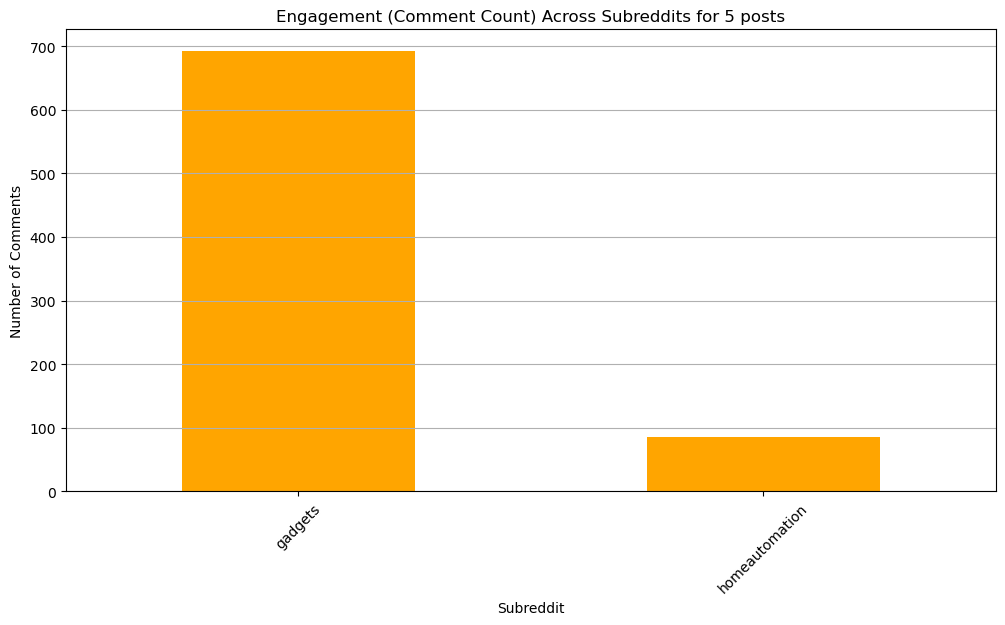

In [21]:
# EDA - Subreddit Engagement (Comments Only)
stats_df.set_index("subreddit")["comments"].plot(kind="bar", figsize=(12, 6), color="orange")
plt.title("Engagement (Comment Count) Across Subreddits for 5 posts")
plt.xlabel("Subreddit")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [22]:
# Categorize Users by Karma
def categorize_user(karma):
    if karma <= 1000:
        return "Lurker"
    elif 1001 <= karma <= 10000:
        return "Regular"
    else:
        return "Superuser"

df["category"] = df["karma"].apply(categorize_user)

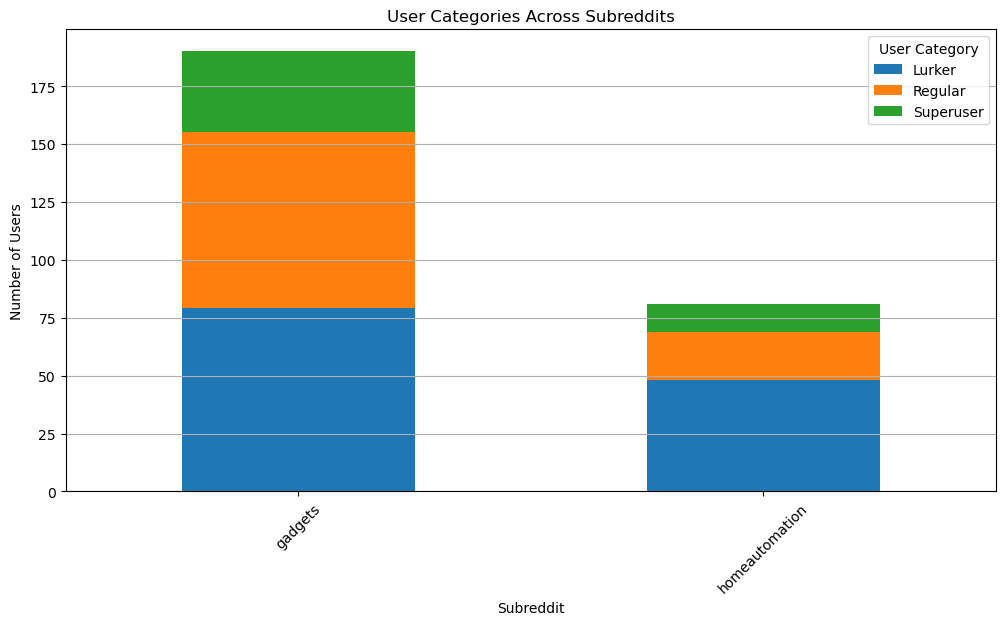

In [23]:
# Visualization After Categorizing Users
def visualize_user_categories(df):
    # Group by subreddit and category to calculate counts
    category_counts = df.groupby(["subreddit", "category"]).size().unstack(fill_value=0)
    
    # Plot stacked bar chart
    category_counts.plot(kind="bar", stacked=True, figsize=(12, 6))
    plt.title("User Categories Across Subreddits")
    plt.xlabel("Subreddit")
    plt.ylabel("Number of Users")
    plt.legend(title="User Category")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

# Call the visualization function
visualize_user_categories(df)

In [24]:
def calculate_weighted_sum(user_df, stats_df, alpha=2, gamma1=2, gamma2=5):
    """
    Calculate weighted sum for each subreddit based on comment/post ratio and user categories.

    Parameters:
    - user_df: DataFrame containing user data with karma and categories.
    - stats_df: DataFrame containing subreddit statistics (comment/post ratio, etc.).
    - alpha: Weight for comment/post ratio.
    - gamma1: Weight for Regular users.
    - gamma2: Weight for Superusers.

    Returns:
    - DataFrame with calculated weighted sums and aggregated data.
    """
    category_counts = user_df.groupby(["subreddit", "category"]).size().unstack(fill_value=0)
    stats_df = stats_df.set_index("subreddit")

    # Merge stats with category counts
    merged_df = category_counts.join(stats_df, how="inner")

    # Calculate weighted sum
    merged_df["weighted_sum"] = (
        alpha * merged_df["comment_post_ratio"] +  # Contribution from comment/post ratio
        gamma1 * merged_df.get("Regular", 0) +    # Contribution from regular users
        gamma2 * merged_df.get("Superuser", 0)    # Contribution from superusers
    )
    return merged_df

In [28]:
final_df = calculate_weighted_sum(df, stats_df)
print("Final Data with Weighted Sum:\n", final_df)

# Find the best subreddit for marketing
best_subreddit = final_df["weighted_sum"].idxmax()
print(f"The best subreddit for marketing is: {best_subreddit}")


Final Data with Weighted Sum:
                 Lurker  Regular  Superuser  posts  comments  \
subreddit                                                     
gadgets             79       76         35      5       692   
homeautomation      48       21         12      5        86   

                comment_post_ratio  weighted_sum  
subreddit                                         
gadgets                      138.4         603.8  
homeautomation                17.2         136.4  
The best subreddit for marketing is: gadgets


In [29]:
# Extracting data from the DataFrame
subreddits = final_df.index.tolist()  # Assuming subreddit names are in the index
comment_post_ratio = final_df['comment_post_ratio'].tolist()
weighted_sum = final_df['weighted_sum'].tolist()

# Print extracted variables to verify
print("Subreddits:", subreddits)
print("Comment Post Ratio:", comment_post_ratio)
print("Weighted Sum:", weighted_sum)



Subreddits: ['gadgets', 'homeautomation']
Comment Post Ratio: [138.4, 17.2]
Weighted Sum: [603.8, 136.4]


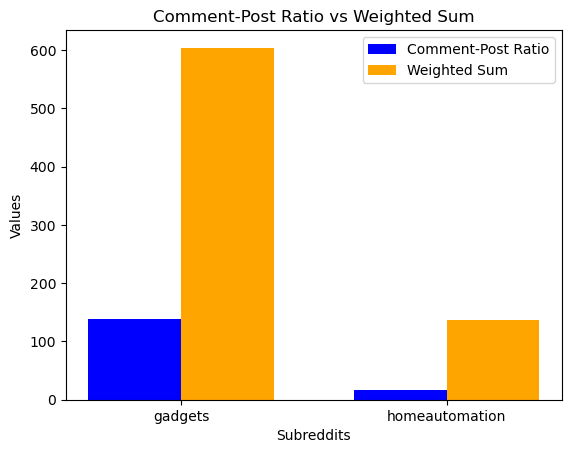

In [33]:
# Grouped Bar Chart for Weighted Sum and Comment-Post Ratio
import numpy as np

x = np.arange(len(subreddits))  # Label locations
width = 0.35  # Width of bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, comment_post_ratio, width, label='Comment-Post Ratio', color='blue')
bars2 = ax.bar(x + width/2, weighted_sum, width, label='Weighted Sum', color='orange')

ax.set_xlabel('Subreddits')
ax.set_ylabel('Values')
ax.set_title('Comment-Post Ratio vs Weighted Sum')
ax.set_xticks(x)
ax.set_xticklabels(subreddits)
ax.legend()

plt.show()
